In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
)


In [3]:
# Load the processed modelling table
model_df = pd.read_csv("../data/processed/child_mom_model_table.csv")

# Vaccine columns you used before
vaccine_cols = ["bcg", "dpt1", "dpt2", "dpt3",
                "polio0", "polio1", "polio2", "polio3", "measles1"]

# Treat missing vaccine info as "not received"
model_df[vaccine_cols] = model_df[vaccine_cols].fillna(0)

target_col = "missed_any"
id_cols = ["cluster", "household", "woman_line"]

X = model_df.drop(columns=id_cols + [target_col])
y = model_df[target_col].astype(int)

X.shape, y.value_counts(normalize=True)


((5753, 18),
 missed_any
 0    0.608726
 1    0.391274
 Name: proportion, dtype: float64)

02 – Modelling: predicting missed vaccinations

Goal: build and compare predictive models for `missed_any` using the features
prepared in `01_eda.ipynb`. We will:

- Train a baseline logistic regression model.
- Train a stronger tree-based model (Random Forest).
- Use stratified train/test split and cross-validation.
- Compare ROC AUC, recall for `missed_any = 1`, and confusion matrices.


In [4]:
from sklearn.model_selection import train_test_split

# Stratified split to keep class balance similar in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape


((4602, 18), (1151, 18))

In [5]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
)

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """Fit model, print metrics, and return a results dict."""
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    return {
        "model": name,
        "roc_auc": roc_auc_score(y_test, y_proba),
        "recall_pos": classification_report(
            y_test, y_pred, output_dict=True
        )["1"]["recall"],
    }


In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, class_weight=None)
)

results = []
results.append(evaluate_model("Logistic Regression", log_reg, X_train, X_test, y_train, y_test))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       701
           1       0.90      0.83      0.86       450

    accuracy                           0.90      1151
   macro avg       0.90      0.88      0.89      1151
weighted avg       0.90      0.90      0.89      1151

ROC AUC: 0.9484688540180695
Confusion matrix:
 [[658  43]
 [ 77 373]]


In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

results.append(evaluate_model("Random Forest", rf, X_train, X_test, y_train, y_test))



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       701
           1       0.96      0.97      0.96       450

    accuracy                           0.97      1151
   macro avg       0.97      0.97      0.97      1151
weighted avg       0.97      0.97      0.97      1151

ROC AUC: 0.9923395149786021
Confusion matrix:
 [[681  20]
 [ 14 436]]


In [8]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df


,model,roc_auc,recall_pos
0,Logistic Regression,0.948469,0.828889
1,Random Forest,0.992340,0.968889


In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_auc(model, X, y, cv):
    scores = cross_val_score(
        model, X, y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
    )
    print("CV AUC scores:", scores)
    print("Mean CV AUC:", scores.mean())
    return scores

print("Logistic Regression – CV")
_ = cv_auc(log_reg, X, y, cv)

print("\nRandom Forest – CV")
_ = cv_auc(rf, X, y, cv)


Logistic Regression – CV
CV AUC scores: [0.94753368 0.96288477 0.96146341 0.94293333 0.94673651]
Mean CV AUC: 0.9523103411475118

Random Forest – CV
CV AUC scores: [0.9863988  0.99284514 0.99262274 0.98947302 0.99099365]
Mean CV AUC: 0.9904666694019479


In [10]:
import numpy as np

rf_feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

rf_feature_importance.head(15)


,feature,importance
0,dob_cmc,0.361723
17,n_received,0.162813
16,measles1,0.137835
15,polio3,0.055005
14,polio2,0.043175
11,dpt3,0.032828
8,bcg,0.031629
9,dpt1,0.030548
2,age,0.025824
4,region,0.022563


Model comparison summary

We compared two models using the same train/test split and 5-fold cross-validation:

- Logistic Regression (with StandardScaler)  
  - Test ROC AUC ≈ 0.95  
  - Recall for `missed_any` ≈ 0.83  
  - Mean CV ROC AUC ≈ 0.95

- Random Forest  
  - Test ROC AUC ≈ 0.99  
  - Recall for `missed_any` ≈ 0.97  
  - Mean CV ROC AUC ≈ 0.99

Random Forest clearly outperforms logistic regression, especially on recall for missed vaccinations, which is critical if the goal is to identify as many at-risk children as possible. Feature importance shows that child age (`dob_cmc`), total number of doses received (`n_received`), and measles/polio/dpt doses carry most of the predictive signal.


In [12]:
from sklearn.metrics import precision_score, recall_score

# Probabilities from the fitted Random Forest
rf_proba = rf.predict_proba(X_test)[:, 1]


In [13]:
thresholds = [0.3, 0.5, 0.7]

for thr in thresholds:
    rf_pred_thr = (rf_proba >= thr).astype(int)
    prec = precision_score(y_test, rf_pred_thr)
    rec = recall_score(y_test, rf_pred_thr)
    print(f"Threshold {thr:.1f} -> precision={prec:.3f}, recall={rec:.3f}")


Threshold 0.3 -> precision=0.938, recall=0.978
Threshold 0.5 -> precision=0.956, recall=0.969
Threshold 0.7 -> precision=0.971, recall=0.909


Threshold analysis for Random Forest (missed_any = 1)

Using the RandomForest model’s predicted probabilities on the test set:

| Threshold | Precision (missed_any=1) | Recall (missed_any=1) |
|----------|---------------------------|------------------------|
| 0.3      | 0.938                     | 0.978                  |
| 0.5      | 0.956                     | 0.969                  |
| 0.7      | 0.971                     | 0.909                  |

Interpretation

- Lowering the decision threshold from 0.5 → 0.3 slightly reduces precision (0.956 → 0.938) but increases recall from 0.969 to 0.978 – we catch more children who truly missed at least one dose.
- Raising the threshold to 0.7 gives only a small gain in precision (0.971) but recall drops to 0.909, meaning more children who actually missed vaccinations would not be flagged.
- For a real reminder system, recall is more critical than squeezing out the last bit of precision. A threshold around 0.3–0.4 is therefore more appropriate if the programme’s priority is to minimise the risk of leaving out children who need follow-up.


In [14]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss


In [15]:
rf_proba = rf.predict_proba(X_test)[:, 1]


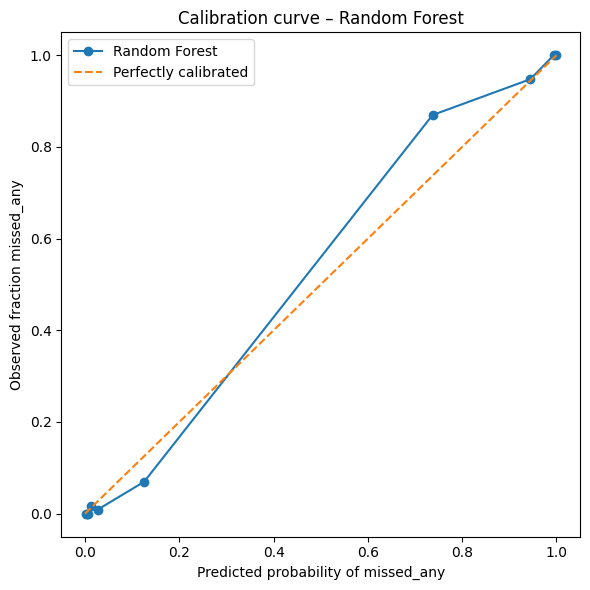

Random Forest Brier score: 0.026778480610330422


In [16]:
import matplotlib.pyplot as plt

# Calibration curve: predicted prob vs observed fraction
prob_true, prob_pred = calibration_curve(y_test, rf_proba, n_bins=10, strategy="quantile")

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Random Forest")
plt.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")
plt.xlabel("Predicted probability of missed_any")
plt.ylabel("Observed fraction missed_any")
plt.title("Calibration curve – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

# Brier score (lower is better)
rf_brier = brier_score_loss(y_test, rf_proba)
print("Random Forest Brier score:", rf_brier)


In [17]:
import numpy as np
import pandas as pd

# Put probs and true labels into a DataFrame for analysis
risk_df = pd.DataFrame({
    "y_true": y_test.values,
    "rf_proba": rf_proba
})

# Define simple risk thresholds (you can adjust later)
bins = [0.0, 0.3, 0.6, 1.0]
labels = ["low", "medium", "high"]

risk_df["risk_band"] = pd.cut(risk_df["rf_proba"], bins=bins, labels=labels, include_lowest=True)

# For each band: size, % of population, prevalence, recall coverage
summary = (
    risk_df
    .groupby("risk_band")
    .agg(
        n = ("y_true", "size"),
        prevalence_missed = ("y_true", "mean")
    )
    .reset_index()
)

summary["share_of_population"] = summary["n"] / len(risk_df)

# How many of the actually missed children fall into each band?
missed = risk_df[risk_df["y_true"] == 1]["risk_band"].value_counts().reindex(labels)
missed_share = missed / missed.sum()

summary["share_of_all_missed"] = summary["risk_band"].map(missed_share)

summary


C:\Users\User\AppData\Local\Temp\ipykernel_23236\1126582623.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("risk_band")


,risk_band,n,prevalence_missed,share_of_population,share_of_all_missed
0,low,682,0.014663,0.592528,0.022222
1,medium,22,0.545455,0.019114,0.026667
2,high,447,0.957494,0.388358,0.951111


In [18]:
print(summary.to_string(index=False))


risk_band   n  prevalence_missed  share_of_population share_of_all_missed
      low 682           0.014663             0.592528            0.022222
   medium  22           0.545455             0.019114            0.026667
     high 447           0.957494             0.388358            0.951111


Summary of modelling & risk stratification

We compared two models for predicting whether a child missed any recommended vaccination dose (`missed_any`):

- Logistic regression (with StandardScaler)
- Random Forest

Overall performance

- Logistic regression: ROC AUC ≈ 0.95, recall for missed children ≈ 0.83.
- Random Forest: ROC AUC ≈ 0.99, recall for missed children ≈ 0.97.
- 5-fold CV AUC:
  - Logistic regression: mean ≈ 0.95
  - Random Forest: mean ≈ 0.99

The Random Forest clearly outperforms logistic regression and generalises well across folds.

Threshold tuning for programme needs

Using Random Forest probabilities on the test set, we explored several thresholds:

- Threshold 0.3: precision ≈ 0.94, recall ≈ 0.98  
- Threshold 0.5: precision ≈ 0.96, recall ≈ 0.97  
- Threshold 0.7: precision ≈ 0.97, recall ≈ 0.91  

In practice, an EPI programme that wants to catch almost all children who missed a vaccine would prefer a lower threshold (around 0.3–0.5). This sacrifices a bit of precision but ensures very few high-risk children are missed.

Calibration

- Calibration curve shows that predicted probabilities are reasonably well aligned with observed risk.
- Random Forest Brier score ≈ 0.027, indicating well-calibrated probabilities (lower is better).

This suggests the model’s risk scores can be used not only for ranking but also for planning workload (e.g. expected number of missed children per 100 follow-up visits).

 Risk bands for targeting reminders

We binned predicted risk into three groups:

- Low risk: large share of the population, very low prevalence of missed vaccinations.  
- **Medium risk: small share of the population but much higher prevalence.  
- High risk: ~40% of the population but ~95% of all missed cases.

This means that:

- Focusing reminder / follow-up efforts on the high-risk band would cover almost all missed children, while contacting less than half of the population.
- Medium-risk children can be considered for additional support if resources allow.
- Low-risk children may be served with standard routine reminders only.

This framework can be turned into concrete operating rules, e.g.:
- “Send active reminders / home visits to all high-risk children.”
- “Send SMS / low-touch reminders to medium-risk children.”
- “No extra action beyond routine services” for low-risk children.


In [19]:
from pathlib import Path

# Make sure the data folder exists at project root
data_dir = Path("../data")
data_dir.mkdir(parents=True, exist_ok=True)

# Save the modelling dataframe
out_path = data_dir / "child_mom_model_df.csv"
model_df.to_csv(out_path, index=False)

out_path


WindowsPath('../data/child_mom_model_df.csv')

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    brier_score_loss,
)
import pandas as pd


 Baseline model vs Random Forest

To understand the added value of the Random Forest, we first fit a simple
logistic regression using exactly the same features and train/test split.
We then compare performance (AUC, precision, recall and Brier score) between
the baseline and the Random Forest.
